1620 3240


Renderizando:  50%|█████     | 350/700 [00:28<00:25, 13.53px/s]C:\Users\User\AppData\Local\Temp\ipykernel_26476\2944625067.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / b**2 - 1 / R**2 + self.rs / R**3
Renderizando: 100%|██████████| 700/700 [00:57<00:00, 12.25px/s]


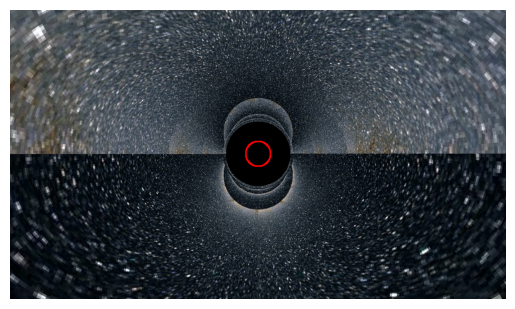

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from PIL import Image
from scipy import optimize
from scipy.special import ellipkinc

class SchwarzschildRayTracer:
    def __init__(self, bh_mass=1.0, image_size_x=700, image_size_y=700):

        self.image_size_x = image_size_x
        self.image_size_y = image_size_y

        self.bh_mass = bh_mass
        self.rs = 2 * bh_mass  # Radio de Schwarzschild
        self.r_start = 200 * self.rs
        self.b_max_x = 20*self.rs
        self.b_max_y = self.b_max_x/image_size_x*image_size_y
        self.r_max =self.r_start*1.1
        self.image = np.zeros((image_size_y, image_size_x, 3), dtype=np.uint8)  # RGB

        
        #self.stars_img = np.array(Image.open("Imágenes/Background_2.png").convert('RGB'))
        self.stars_img = np.array(Image.open("../data/Background_1.jpg").convert('RGB'))
        #self.stars_img = np.array(Image.open("Imágenes/Estrellas.jpg").convert('RGB'))

        self.stars_height, self.stars_width = self.stars_img.shape[:2]
        print(self.stars_height, self.stars_width)

    def equation(self, phi, y, b):
        # y = [r, dr/dphi]
        r, dr_dphi = y
        f = 1 - self.rs / r
        d2r_dphi2 = (f * (self.r_start**2 / b**2) - f * (dr_dphi**2) / r - f * r)
        return [dr_dphi, d2r_dphi2]
    
    def trace_ray(self, b, theta_view):

        phi = np.arcsin(b / (self.r_start**2+b**2 ))  #b>0 ->[0, π/2]
        
        def colour(phi, theta_view, alpha):
            #phi_max = np.arcsin(np.clip(self.b_max / (self.r_start**2+self.b_max**2 ), -1, 1)) %  (2*np.pi)

            beta_1 = ((phi-alpha) * np.cos(theta_view))  #[-π/2,π/2]
            beta_2 = ((phi-alpha) * np.sin(theta_view)) #[-π/2,π/2]

            #print(beta_1)
 
            if beta_2>0:
                x_c = int(self.stars_width/4)
                y_c = int(self.stars_height/4)
            else:
                x_c = int(self.stars_width/4 *3)
                y_c = int(self.stars_height/4)
                
            x_img = x_c+ int((beta_1 * self.stars_width/4) % (self.stars_height/4))
            y_img = y_c+ int((beta_2 * self.stars_height/4) % (self.stars_height/4))

            return self.stars_img[y_img, x_img]

        def rmin(R, b):
            return 1 / b**2 - 1 / R**2 + self.rs / R**3

        r_min = self.rs * 3/2
        r_max = self.r_max

        fa = rmin(r_min, b)
        fb = rmin(r_max, b)

        if fa * fb > 0:
            return [0, 0, 0]  # No hay raíz en este intervalo: descarta este rayo
        #elif b<1.e-10:
        #    return [0, 0, 0]  # No hay raíz en este intervalo: descarta este rayo
        else:
            sol = optimize.root_scalar(rmin, bracket=[r_min, r_max], args=(b,), method='brentq')
            rm = sol.root
        
        if b<1.001*self.rs:
            return [0, 0, 0]  # No hay raíz en este intervalo: descarta este rayo
        
        s=np.sqrt((rm-self.rs)*(rm+3*self.rs))
        m=(s-rm+3*self.rs)/2/s
        arg=np.sqrt(2*s/(3*rm-3*self.rs+s))
        arg = np.clip(arg, -1.0, 1.0)
        varphi=np.arcsin(arg)
        
        alpha=(4*np.sqrt(b/s)*float(ellipkinc(varphi, m)) -np.pi)% (np.pi)  #[0, π]
        #print(alpha)
        
        if np.isnan(alpha):
            return [0,0,0]
        else:
            return colour(phi, theta_view, alpha)


    def render(self):
        
        b_max_x = self.b_max_x
        b_max_y = self.b_max_y
        d=np.sqrt(self.image_size_x**2/self.image_size_y**2+1)
        with tqdm(total=self.image_size_y, desc="Renderizando", unit="px") as pbar:

            for i in range(self.image_size_y):
                for j in range(self.image_size_x):

                    x = (j - self.image_size_x / 2) / (self.image_size_x / 2) * b_max_x
                    y = (i - self.image_size_y / 2) / (self.image_size_y / 2) * b_max_y
                    
                    theta_view = np.arctan2(y, x)
                    b = np.sqrt(x**2 + y**2)

                    A= ((self.rs*np.cos(theta_view) - 2 * b_max_x / (self.image_size_x / 2) < x) and (x<self.rs*np.cos(theta_view) + 2 * b_max_x / (self.image_size_x / 2) ))
                    B= ((self.rs*np.sin(theta_view) - 2 * b_max_y / (self.image_size_y / 2) < y) and (y<self.rs*np.sin(theta_view) + 2 * b_max_y / (self.image_size_y / 2) ))

                    if A and B :
                        self.image[i, j] = [255,0,0]
                        #print("red")
                    else:
                        theta_view = np.arctan2(y, x)
                        color = self.trace_ray(b, theta_view)
                        self.image[i, j] = color
                pbar.update(1)


        plt.imshow(self.image, cmap='gray', origin='lower')
        #plt.title("Sombra del agujero negro (modelo simple)")
        plt.axis('off')
        #plt.show()
        plt.savefig("../Multimedia/Agujero_negro/Sombra del agujero negro.png")

rt = SchwarzschildRayTracer(image_size_x=1200, image_size_y=700, bh_mass=1.0)
rt.render() # máximo parámetro de impacto

